In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

# from google.colab import drive
# import sys
# drive.mount('/content/gdrive')
# sys.path.append('/content/gdrive/My Drive/Colab Notebooks/FIRE298')

# from dataGens import ImageSequenceGenerator, FakeAttributeSequenceGenerator
# from dcgan import DCGAN

In [2]:
### Code from Imports ###
# The imports do not work without access permission so the code is pulled in here

from tensorflow.keras.utils import Sequence
import numpy as np
import cv2

class ImageSequenceGenerator(Sequence):
    def __init__(self, dataset, size, model, image_size=(160, 192)):
        self.data = dataset
        self.batch_size = int(size / 2)
        self.model = model
        self.image_size = image_size

    def __getitem__(self, idx):
        images = self.data.skip(self.batch_size * idx).take(self.batch_size)
        real_image = [cv2.resize(np.array(i["image"]), dsize=self.image_size, interpolation=cv2.INTER_CUBIC) / 127.5 - 1 for
                      i in images]
        x_input = np.random.randint(2, size=(self.batch_size, 40))
        x_input = np.concatenate((x_input, np.random.uniform(size=(self.batch_size, 1))), axis=1)
        fake_image = np.reshape(self.model.predict(x_input),
                                (self.batch_size, self.image_size[1], self.image_size[0], 3))

        batch_x = np.concatenate((real_image, fake_image))
        batch_y = np.concatenate(
            (np.zeros((self.batch_size, 1), dtype=int), np.ones(((self.batch_size), 1), dtype=int)))

        return np.array(batch_x), np.array(batch_y)
    
    def shuffle(self):
        self.data.shuffle(10000)

class FakeAttributeSequenceGenerator(Sequence):
    def __init__(self, batch_size=64, latent_dim=41):
        self.batch_size = batch_size
        self.latent_dim = latent_dim
    
    def __getitem__(self, idx):
        attrs = np.random.randint(2, size=(self.batch_size, self.latent_dim - 1))
        noise = np.random.uniform(size=(self.batch_size, 1))
        attrs = np.concatenate((attrs, noise), axis=1)
        
        truth = np.zeros((self.batch_size, 1), dtype = int) 
        
        return attrs, truth

from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D, Conv2DTranspose
from keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
import numpy as np
import os

class DCGAN():
    def __init__(self, dataset, path='', epoch_num=-1, img_rows=64, img_cols=64, channels=3, latent_dim=41, gf=64, df=64):
        # Save parameters
        self.dataset = dataset
        self.img_rows = img_rows
        self.img_cols = img_cols
        self.channels = channels
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = latent_dim
        self.gf = gf
        self.df = df
        self.lossMean = [[],[]]
        self.lossEnd = [[],[]]

        dOptimizer = Adam(0.0001, 0.5)
        gOptimizer = Adam(0.0002, 0.5)
        
        ### Generator Model ###
        # Build the generator
        self.generator = self.build_generator()

        ### Discriminator Model ###
        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=dOptimizer,
            metrics=['accuracy'])
        
        ### Load Models if Given ###
        if path != '':
            if epoch_num < 0:
                self.load_model(path=path)
            else:
                self.load_model(path=path, epoch_num=epoch_num)
        
        ### Combined Model: GAN ###
        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)
        
        # For the combined model we will only train the generator
        self.discriminator.trainable = False
        valid = self.discriminator(img)
        
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=gOptimizer)
        print("Built GAN Model")
        
    def getBase(self):
        power = 0
        startR = self.img_rows
        startC = self.img_cols
        
        while (startR > 10 and startC > 10 and
               startR % 2 == 0 and startC % 2 == 0):
            power += 1
            startR /= 2
            startC /= 2
        return (int(startR), int(startC)), power

    def build_generator(self):
        start, power = self.getBase()
        
        def g_block(model, filters):
            # Convolution layers
            model.add(UpSampling2D())
            model.add(Conv2D(filters, kernel_size=5, padding="same"))
            
            # Batch normalization and Activation
            model.add(BatchNormalization(momentum=0.8))
            model.add(Activation("relu"))
        
        ### Build Model ###
        model = Sequential()
        
        # Input layers
        model.add(Dense(self.gf * (2 ** power) * start[0] * start[1], activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((start[0], start[1], self.gf * (2 ** power))))
        
        # Upscaling convolutionary layer blocks
        for f in range(power, 0, -1):
            g_block(model, self.gf * (2 ** f))

        # Format output
        model.add(Conv2D(self.channels, kernel_size=5, padding="same"))
        model.add(Activation("tanh"))

        # Display Model
        model.summary()

        # Join layers into a model
        noise = Input(shape=(self.latent_dim,))
        img = model(noise)
        
        print("Built Generator")
        return Model(noise, img)
    
    def build_discriminator(self):

        def d_block(model, filters, strides=2, bn=True, input_size=False):
            # Convolution layer with optional input shape
            if input_size:
                model.add(Conv2D(filters, kernel_size=4, strides=strides, input_shape=self.img_shape, padding="same"))
            else:
                model.add(Conv2D(filters, kernel_size=4, strides=strides, padding="same"))
            
            # Optional Batch normalization
#             if bn:
#                 model.add(BatchNormalization(momentum=0.8))
            
            # Activation and Dropout
            model.add(LeakyReLU(alpha=0.2))
            model.add(Dropout(0.25))

        ### Build Model ###
        model = Sequential()
        
        # Repetative inner layer blocks
        d_block(model, self.df * 1, bn=False, input_size=True) # Input layer
        d_block(model, self.df * 2)
        d_block(model, self.df * 4)
        d_block(model, self.df * 8, strides=1) # End
        
        # Format output
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))
        
        # Display Model
        model.summary()

        # Join layers into a model
        img = Input(shape=self.img_shape)
        validity = model(img)

        print("Built Discriminator")
        return Model(img, validity)

    def train(self, epochs, batch_num=100, batch_size=128, save_interval=5):

        # Load the datasets
        gDataGen = FakeAttributeSequenceGenerator(batch_size=batch_size, latent_dim=self.latent_dim)
        dDataGen = ImageSequenceGenerator(self.dataset, batch_size, self.generator, image_size=(self.img_rows,self.img_cols))
        self.lossMean = [[],[]]
        self.lossEnd = [[],[]]
        
        for epoch in range(epochs):
            print ("\n----- Epoch %d -----\n" % (epoch))
            loss_temp = [[],[]]
            
            for batch in range(batch_num):
                ### Train Discriminator ###
                # Get Discriminator training data
                d_input, d_output = dDataGen[batch]
                # Train the Discriminator
                d_loss = self.discriminator.train_on_batch(d_input, d_output)

                ### Train Generator ###
                # Get Generator training data
                g_input, g_output = gDataGen[batch]
                # Train the Generator
                g_loss = self.combined.train_on_batch(g_input, g_output)
                
                # Save Loss Values
                loss_temp[0].append(g_loss)
                loss_temp[1].append(d_loss[0])
                
                # Print training results
                print ("Batch %d/%d - Discrim loss: %f, accuracy: %.2f%%\n             - Gener loss: %f" %
                       (batch, batch_num, d_loss[0], 100*d_loss[1], g_loss))
                
            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                dDataGen.shuffle()
                self.save_imgs(epoch)
                self.save_model(epoch_num=epoch)
                
                loss_temp = np.mean(np.array(loss_temp), axis=1)
                self.lossMean[0].append(loss_temp[0])
                self.lossMean[1].append(loss_temp[1])
                self.lossEnd[0].append(g_loss)
                self.lossEnd[1].append(d_loss[0])
                
        self.loss_plot(self.lossMean, path='sampleImgs/mean_')
        self.loss_plot(self.lossEnd, path='sampleImgs/end_')
        
    def save_imgs(self, epoch, path='sampleImgs/'):
        r, c = 5, 5
        
        noise1 = np.random.randint(2, size=(25, self.latent_dim - 1))
        noise2 = np.random.uniform(size=(25, 1))
        noise = np.concatenate((noise1, noise2), axis=1)
        
        gen_imgs = self.generator.predict(noise)
        predicts = self.discriminator.predict(gen_imgs)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c, figsize=(self.img_rows/4, self.img_cols/4))
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[i * c + j])
                axs[i,j].set_title(int(predicts[i * c + j][0] * 10000) / 100, fontsize = self.img_rows/4)
                axs[i,j].axis('off')
                
        plt.tight_layout()
        fig.savefig(path + "epoch_%d.png" % epoch)
        plt.close()
        
    def save_model(self, path='models/', epoch_num=-1):
        if not os.path.isdir(path):
            os.mkdir(path)
            
        if epoch_num < 0:
            self.generator.save(path+'gen.h5')
            self.discriminator.save(path+'disc.h5')
        else:
            self.generator.save(path+'gen_'+str(epoch_num)+'.h5')
            self.discriminator.save(path+'disc_'+str(epoch_num)+'.h5')
        
        print("Saved Models")


    def load_model(self, path='models/', epoch_num=-1):
        try:
            if epoch_num < 0:
                self.generator.load_weights(path+'gen.h5')
                self.discriminator.load_weights(path+'disc.h5')
            else:
                self.generator.load_weights(path+'gen_'+str(epoch_num)+'.h5')
                self.discriminator.load_weights(path+'disc_'+str(epoch_num)+'.h5')
                
            print("Loaded Generator and Discriminator")
        except:
            print("Error: Failed to Load Models")
            
    def loss_plot(self, epochs, path='sampleImgs/'):
        plt.xlabel('epochs')
        plt.ylabel('loss')
        
        plt.plot(epochs[0], label="Gen Loss")
        plt.plot(epochs[1], label="Disc Loss")
        
        plt.legend(loc='upper left')
        plt.title("Loss over Epochs")
        
        plt.savefig(path + 'lossPlot.png')
        plt.close()

In [3]:
dcgan = DCGAN(None, path='gdrive/My Drive/Colab Notebooks/FIRE298-FaceGen/models/', epoch_num=104, img_rows=128, img_cols=128)
attrData = FakeAttributeSequenceGenerator(batch_size=4)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 65536)             2752512   
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 1024)        0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 16, 16, 1024)      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 16, 16, 1024)      26215424  
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 16, 1024)      4096      
_________________________________________________________________
activation (Activation)      (None, 16, 16, 1024)      0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 32, 32, 1024)      0

In [4]:
### Attribute Noise ###
'''
The Attribute Data Noise is the input to the Generator and GAN Models.
It is a random list of 40 elements (1s and 0s) with a float value between 0-1 at
the end. This corrisponds to the true/false attribute data that comes with the
CelebA dataset. In the future, the Discriminator model could be feed the
Attribute data and use that to have the inputted attributes corrispond with the
actual meaning of each value allowing for the creation of specific faces.

This data gen also produces truth values to compare with the Descriminator output.
The truth values for this, however, are lies (they are 0s which corrispond with
the images being real) since the Generator is trying to trick the Descriminator.
'''

exampleAttrs, truthValue = attrData[0]
print("Attribute Data Noise Shape: " + str(exampleAttrs.shape))
print("Attribute Data Noise 1 Batch:\n" + str(exampleAttrs[0]))
print("Attribute Data Truth Shape: " + str(truthValue.shape))
print("Attribute Data Truth 1 Batch: " + str(truthValue[0]))

Attribute Data Noise Shape: (4, 41)
Attribute Data Noise 1 Batch:
[0.        1.        1.        0.        1.        1.        0.
 1.        0.        0.        0.        0.        1.        1.
 0.        0.        0.        1.        1.        0.        1.
 0.        1.        1.        0.        0.        1.        0.
 0.        1.        1.        1.        1.        1.        1.
 1.        1.        0.        0.        1.        0.1926816]
Attribute Data Truth Shape: (4, 1)
Attribute Data Truth 1 Batch: [0]


Generated Images Shape: (4, 128, 128, 3)
Generated Images:


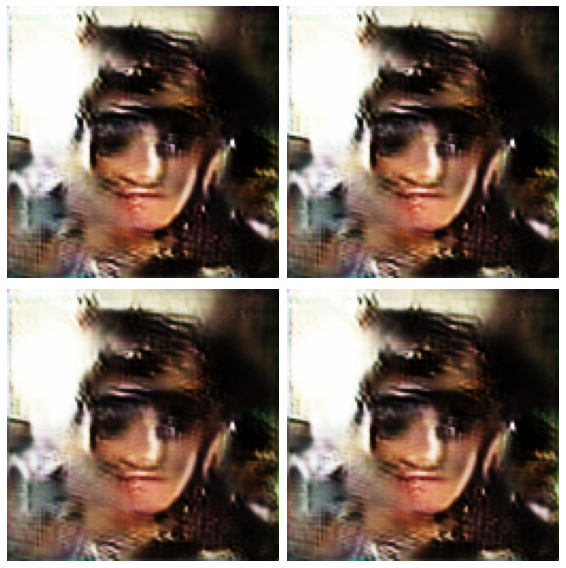

In [5]:
### Generator Model ###
'''
The Generator Model uses the Attribute Data Noise as input
into a Deep Convolutional Network that starts with a small
image and upscales it through each grouping of layers.

In the end it creates a batch of rgb images designed to
trick the Descriminator Model into thinking its a face.

*Note*
The four images below are created from 4 different, random inputs
but look the same. A potential reason for this is that the generator
Model has no incentive to change the image based on the input
since the Descriminator Model is blind to the input.
This could be an important fix for future versions of this.
'''

genImages = dcgan.generator.predict(exampleAttrs)
print("Generated Images Shape: " + str(genImages.shape))
print("Generated Images:")
genImagesDisplay = 0.5 * genImages + 0.5
fig, axs = plt.subplots(2, 2, figsize=(8,8))
for i in range(2):
    for j in range(2):
        axs[i,j].imshow(genImagesDisplay[i * 2 + j])
        axs[i,j].axis('off')
        
plt.tight_layout()
plt.show()

In [6]:
### Discriminator Model ###
'''
The Descriminator Model uses real or fake images as input
into a Deep Convolutional Network which outputs a single value on a scale of 0-1
for each image that represents whether the Model thinks the image contains a
face (a value closer to 0) or no face (a value closer to 1).

This Model is trained half with real images from the CelebA dataset and half
with fake images generated by the current version on the Generator Model and the
corrisponding truth values.
'''

discPrediction = dcgan.discriminator.predict(genImages)
print("Discriminator Predictions Shape: " + str(discPrediction.shape))
print("Discriminator Predictions:\n" + str(discPrediction))

Discriminator Predictions Shape: (4, 1)
Discriminator Predictions:
[[0.86095905]
 [0.86234033]
 [0.91086817]
 [0.88725495]]


In [7]:
### GAN Model ###
'''
The GAN Model is the combination of the Generator and the Descriminator Models.
An input layer is fed into the Generator which is fed into the Descriminator.
The Attribute Data Noise is used as the input and the output is the predicted
truth values based on the generated image from the Generator being passed into
the Descriminator.

The GAN Model is trained with Attribute Data Noise and fake truth values with
the trainability of the Descriminator model turned off. This means only the
Generator Model is trained. It is trained with fake truth values because it is
the Generator Model's goal to trick the Descriminator Model thus it is good for
the Generator Model when the Descriminator Model gets the answer wrong.
'''

ganOutput = dcgan.combined.predict(exampleAttrs)
print("Fake Truth Values Shape: " + str(truthValue.shape))
print("Fake Truth Values:\n" + str(truthValue))
print("GAN Output Shape: " + str(ganOutput.shape))
print("GAN Output:\n" + str(ganOutput))

Fake Truth Values Shape: (4, 1)
Fake Truth Values:
[[0]
 [0]
 [0]
 [0]]
GAN Output Shape: (4, 1)
GAN Output:
[[0.86095905]
 [0.86234033]
 [0.91086817]
 [0.88725495]]


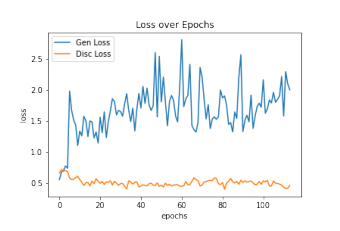

In [8]:
### Training Loss Plot ###
img = mpimg.imread('gdrive/My Drive/Colab Notebooks/FIRE298-FaceGen/mean_lossPlot.png')
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()